# Harmonic Patterns Detection / Study

In [1]:
import yfinance as yf
import pandas as pd
import talib
import numpy as np
from django.http import JsonResponse
from datetime import datetime, timedelta
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
from tqdm import tqdm

# S&P 500 → ^GSPC
# Dow Jones → ^DJI
# Nasdaq 100 → ^NDX
# Russell 2000 → ^RUT
# DAX (Alemanha) → ^GDAXI
# Definir o ticker da ação
symbol = "AAPL"  # Apple Inc.
# symbol = "^GSPC"  # Apple Inc.
# symbol = "XLK"  # Apple Inc.

# Definir período e intervalo
period = "1y"       # Período de 1 mês
interval = "1d"      # Dados diários

yahoo_symbol_info = yf.Ticker(symbol).info

In [3]:
def get_data_history(symbol : str, period : str, interval : str, start = '1900-01-01', end = datetime.now(), prepost : bool = True):
        '''
        Data collection from yahoo

        Parameters:
        period : str
            Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max Either Use period parameter or use start and end
        interval : str
            Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo Intraday data cannot extend last 60 days
        start: str
            Download start date string (YYYY-MM-DD) or _datetime, inclusive. Default is 1900-01-01 E.g. for start="2020-01-01", the first data point will be on "2020-01-01"
        end: str
            Download end date string (YYYY-MM-DD) or _datetime, exclusive. Default is now E.g. for end="2023-01-01", the last data point will be on "2022-12-31"
        prepost : bool
            Include Pre and Post market data in results? Default is False
        '''
        yahoo_data_history = yf.Ticker(symbol).history(period=period, interval=interval, start=start, end=end, prepost=prepost)
        yahoo_data_history.reset_index(inplace=True)

        yahoo_data_history["Date"] = yahoo_data_history["Date"].dt.strftime("%Y-%m-%d %H:%M")

        return yahoo_data_history

data = get_data_history("EURCAD=X", period, interval)

___Harmonic Patterns___ são suvjetivos, são padrões que encaixam no comportamento historico de um preço e não onde o preço encaixa.
É defenido por qualquer padrão predefinido cuja finalidade é fazer uma previsão.
Scott Carney foi o "criador" do padrões classicos [Harmonic Trading Book REF]

Fibonacci Ratios - Devide each number bu eithr the number behind it or front ´
    * this converg to a number 0,618
    backward = 1,618

Retracements - Any price movement that goes agains price move before

Lista de Padrões Harmonicos:

__Classic Patterns Types:__
* Gartley
* Butterfly
* Bat
* Crab

__Other Types:__
* Cypher
* Anti-crab(or any other classical pattern)
* Alternte-crab(or any other classical pattern)

Primeiramente há que reconhecer que tanto padrões harmonicos como fibonacci, e sendo os padroes harmonicos baseados em retracements de fibonacci, são padrões que encaixam no preço e não padrões onde o preço encaixa. Desconsiderando o grau de acertividade das seguintes comparações e baseado somente em aplicabilidade de analise tecnica, enquanto padrões como duplo topo, ombro cabeça ombro são padrões visualmente estaticos onde o preço encaixa e dai tenderá numa progressão, com padrões harmonicos o mesmo não acontece tão simplesmente, pois terá de ser sempre considerado o ultimo minimo ou maximo para que tal aconteça, e os resultados que são passados a decisão obtimos por esta metrica são passados a deecisão somente quando ha a confirmação de um padrão e o estamos 1 vela de 1 Dia a confirmar a tendencia. 


Reforço que todo o desenvolvimento foi feito por uma pessoa só e que a Matris pretende essencialmente receber todo o feedback possivel de forma a atribuir esse conhecimento ao Modelo.


In [4]:
data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,5535.000000,5535.000000,5535.000000,5535.000000,5535.0,5535.0,5535.0
mean,1.463265,1.468837,1.457681,1.463188,0.0,0.0,0.0
std,0.090006,0.090714,0.089319,0.089992,0.0,0.0,0.0
min,1.215940,1.222300,1.212600,1.215600,0.0,0.0,0.0
25%,1.405600,1.410900,1.400150,1.405550,0.0,0.0,0.0
50%,1.466430,1.470820,1.461840,1.466440,0.0,0.0,0.0
75%,1.521520,1.526790,1.515715,1.521200,0.0,0.0,0.0
max,1.719400,1.749800,1.707400,1.719800,0.0,0.0,0.0


In [5]:
def peak_detect(close, order=5):
    '''
    This function find the peaks of a timeframe    
    '''

    max_idx = list(argrelextrema(close, comparator=np.greater, order=order)[0])
    min_idx = list(argrelextrema(close, comparator=np.less, order=order)[0])

    idx = max_idx + min_idx + [len(close)-1]

    idx.sort()

    current_idx = idx[-5:]

    start = min(current_idx)
    end = max(current_idx)

    current_pat = close[current_idx]

    return current_idx, current_pat, start, end, idx

In [7]:
def get_gartley_hp(moves, err_allowed):
        
    XA = moves[0]
    AB = moves[1]
    BC = moves[2]
    CD = moves[3]
                
    AB_range = np.array([.618 - err_allowed, .618 + err_allowed]) * abs(XA)
    BC_range = np.array([.382 - err_allowed, .886 + err_allowed]) * abs(AB)
    CD_range = np.array([1.27 - err_allowed, 1.618 + err_allowed]) * abs(BC)


    # peak information
    peaks = {
        "XA": None,
        "AB": None,
        "BC": None,
        "CD": None
    }

    ## === Bulish Butterfly === ## 
    if XA > 0 and AB < 0 and BC > 0 and CD < 0:

        if AB_range[0] < abs(AB) < AB_range[1] and BC_range[0] < abs(BC) < BC_range[1] and CD_range[0] < abs(CD) < CD_range[1]:
            peaks["XA"] = XA
            peaks["AB"] = AB
            peaks["BC"] = BC
            peaks["CD"] = CD
            return 1, peaks  # Bullish Crab
        else:
            return np.NAN, peaks

    ## === Bearish Butterfly === ## 
    elif XA < 0 and AB > 0 and BC < 0 and CD > 0:

        if AB_range[0] < abs(AB) < AB_range[1] and BC_range[0] < abs(BC) < BC_range[1] and CD_range[0] < abs(CD) < CD_range[1]:
            peaks["XA"] = XA
            peaks["AB"] = AB
            peaks["BC"] = BC
            peaks["CD"] = CD
            return -1, peaks  # Bullish Crab
        else:
            return np.NAN

    else:
        return np.NAN 

In [8]:
def get_butterfly_hp(moves, err_allowed):
        
    XA = moves[0]
    AB = moves[1]
    BC = moves[2]
    CD = moves[3]
                
    AB_range = np.array([.786 - err_allowed, .786 + err_allowed]) * abs(XA)
    BC_range = np.array([.382 - err_allowed, .886 + err_allowed]) * abs(AB)
    CD_range = np.array([1.618 - err_allowed, 2.618 + err_allowed]) * abs(BC)


    # peak information
    peaks = {
        "XA": None,
        "AB": None,
        "BC": None,
        "CD": None
    }

    ## === Bulish Butterfly === ## 
    if XA > 0 and AB < 0 and BC > 0 and CD < 0:

        if AB_range[0] < abs(AB) < AB_range[1] and BC_range[0] < abs(BC) < BC_range[1] and CD_range[0] < abs(CD) < CD_range[1]:
            peaks["XA"] = XA
            peaks["AB"] = AB
            peaks["BC"] = BC
            peaks["CD"] = CD
            return 1, peaks  # Bullish Crab
        else:
            return np.NAN, peaks

    ## === Bearish Butterfly === ## 
    elif XA < 0 and AB > 0 and BC < 0 and CD > 0:

        if AB_range[0] < abs(AB) < AB_range[1] and BC_range[0] < abs(BC) < BC_range[1] and CD_range[0] < abs(CD) < CD_range[1]:
            peaks["XA"] = XA
            peaks["AB"] = AB
            peaks["BC"] = BC
            peaks["CD"] = CD
            return -1, peaks  # Bullish Crab
        else:
            return np.NAN

    else:
        return np.NAN 

In [9]:
def get_bat_hp(moves, err_allowed):
        
    XA = moves[0]
    AB = moves[1]
    BC = moves[2]
    CD = moves[3]
                
    AB_range = np.array([.382 - err_allowed, .5 + err_allowed]) * abs(XA)
    BC_range = np.array([.382 - err_allowed, .886 + err_allowed]) * abs(AB)
    CD_range = np.array([1.618 - err_allowed, 2.618 + err_allowed]) * abs(BC)


    # peak information
    peaks = {
        "XA": None,
        "AB": None,
        "BC": None,
        "CD": None
    }

    ## === Bulish Butterfly === ## 
    if XA > 0 and AB < 0 and BC > 0 and CD < 0:

        if AB_range[0] < abs(AB) < AB_range[1] and BC_range[0] < abs(BC) < BC_range[1] and CD_range[0] < abs(CD) < CD_range[1]:
            peaks["XA"] = XA
            peaks["AB"] = AB
            peaks["BC"] = BC
            peaks["CD"] = CD
            return 1, peaks  # Bullish Crab
        else:
            return np.NAN, peaks

    ## === Bearish Butterfly === ## 
    elif XA < 0 and AB > 0 and BC < 0 and CD > 0:

        if AB_range[0] < abs(AB) < AB_range[1] and BC_range[0] < abs(BC) < BC_range[1] and CD_range[0] < abs(CD) < CD_range[1]:
            peaks["XA"] = XA
            peaks["AB"] = AB
            peaks["BC"] = BC
            peaks["CD"] = CD
            return -1, peaks  # Bullish Crab
        else:
            return np.NAN

    else:
        return np.NAN 

In [10]:
def get_crab_hp(moves, err_allowed):
        
    XA = moves[0]
    AB = moves[1]
    BC = moves[2]
    CD = moves[3]
                
    AB_range = np.array([.382 - err_allowed, .618 + err_allowed]) * abs(XA)
    BC_range = np.array([.382 - err_allowed, .886 + err_allowed]) * abs(AB)
    CD_range = np.array([2.24 - err_allowed, 3.618 + err_allowed]) * abs(BC)

    # peak information
    targets = {
        "XA": None,
        "AB": None,
        "BC": None,
        "CD": None
    }

    ## === Bulish Butterfly === ## 
    if XA > 0 and AB < 0 and BC > 0 and CD < 0:

        if AB_range[0] < abs(AB) < AB_range[1] and BC_range[0] < abs(BC) < BC_range[1] and CD_range[0] < abs(CD) < CD_range[1]:
            targets["XA"] = XA # 3rd Target
            targets["AB"] = AB # 1st Target
            targets["BC"] = BC # 2nd Target
            targets["CD"] = CD # Last Break Point
            
            return 1 # Buy
        else:
            return np.NAN

    ## === Bearish Butterfly === ## 
    elif XA < 0 and AB > 0 and BC < 0 and CD > 0:

        if AB_range[0] < abs(AB) < AB_range[1] and BC_range[0] < abs(BC) < BC_range[1] and CD_range[0] < abs(CD) < CD_range[1]:
            targets["XA"] = XA # 3rd Target
            targets["AB"] = AB # 1st Target
            targets["BC"] = BC # 2nd Target
            targets["CD"] = CD # Last Break Ppint
            
            return -1 # Sell
        else:
            return np.NAN

    else:
        return np.NAN 

  0%|          | 0/5435 [00:00<?, ?it/s]C:\Users\joaom\AppData\Local\Temp\ipykernel_4164\2084060036.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  harmonics = np.array([gart, butt, bat, crab])


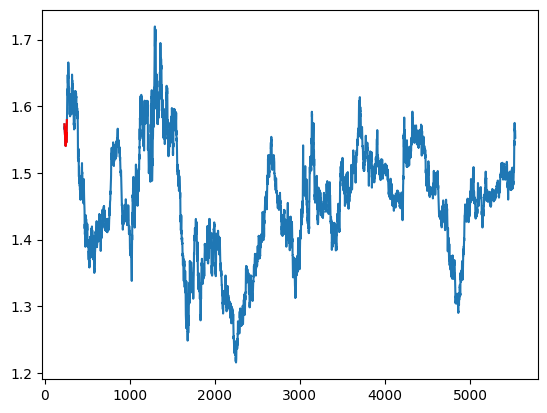

  3%|▎         | 162/5435 [00:00<00:05, 931.06it/s]

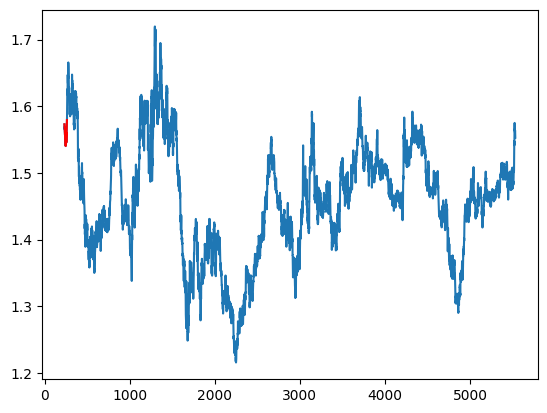

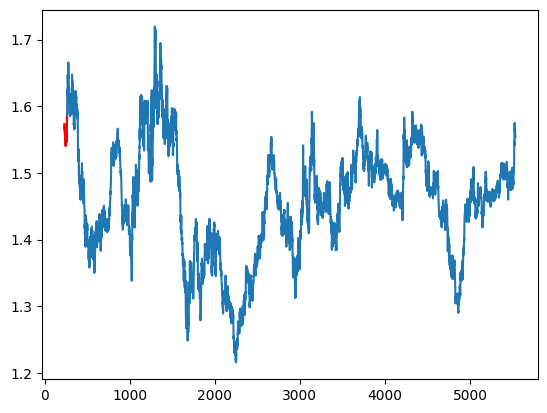

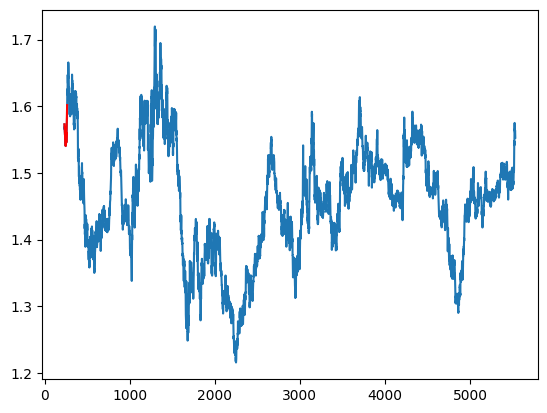

  5%|▍         | 256/5435 [00:00<00:09, 547.52it/s]

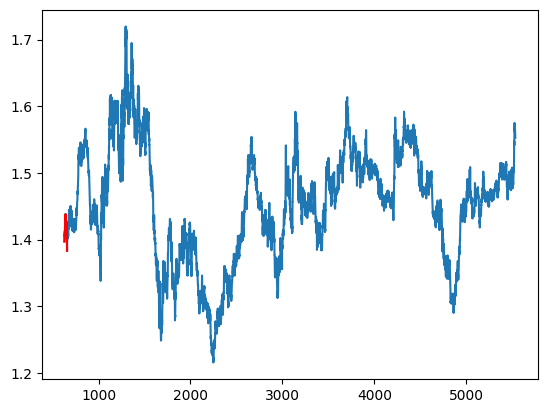

 10%|█         | 560/5435 [00:00<00:04, 1108.64it/s]

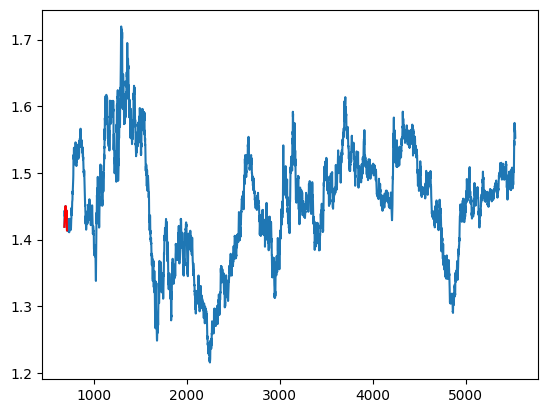

 20%|█▉        | 1075/5435 [00:00<00:02, 1845.18it/s]

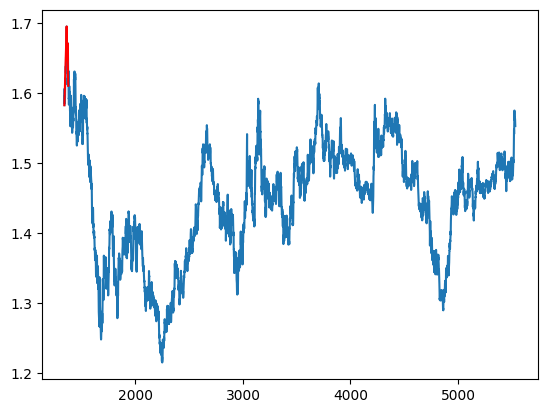

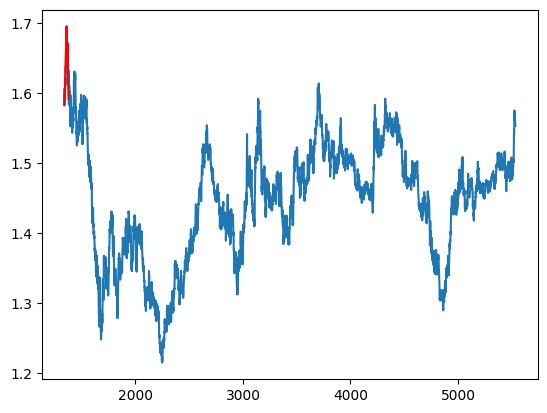

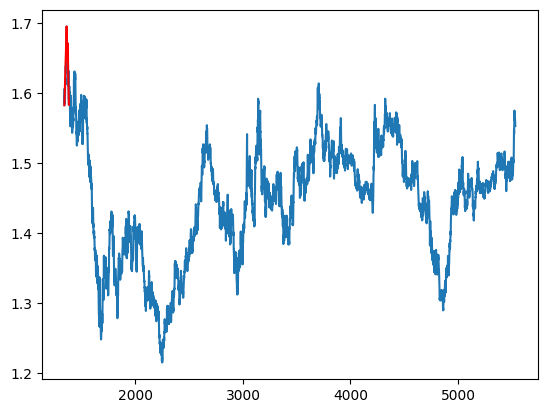

 24%|██▍       | 1294/5435 [00:01<00:04, 1030.66it/s]

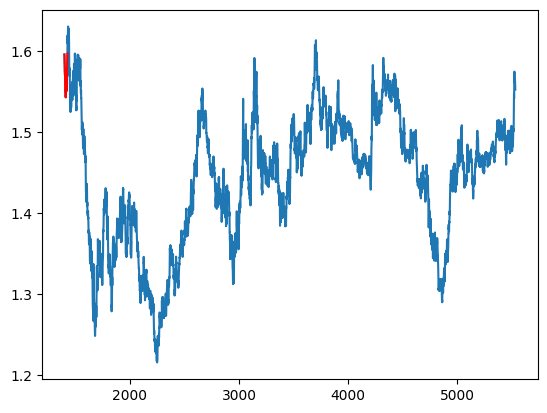

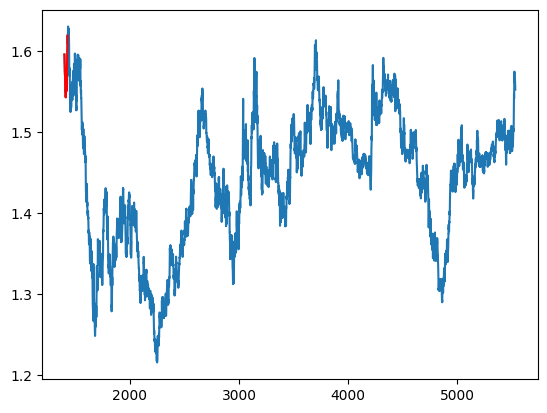

 32%|███▏      | 1715/5435 [00:01<00:02, 1250.42it/s]

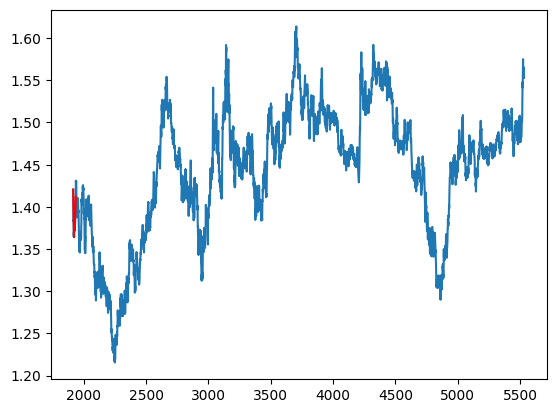

 48%|████▊     | 2611/5435 [00:01<00:01, 1820.46it/s]

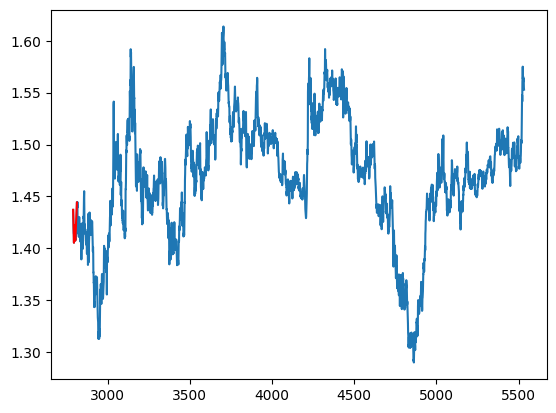

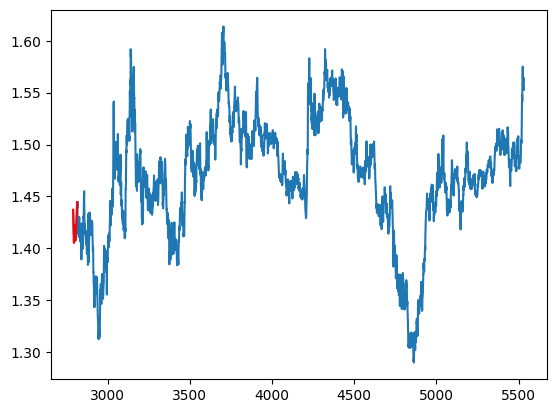

 52%|█████▏    | 2820/5435 [00:02<00:02, 1284.09it/s]

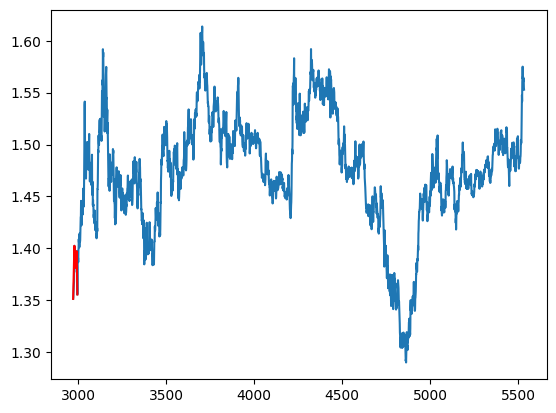

 71%|███████▏  | 3881/5435 [00:02<00:00, 1582.94it/s]

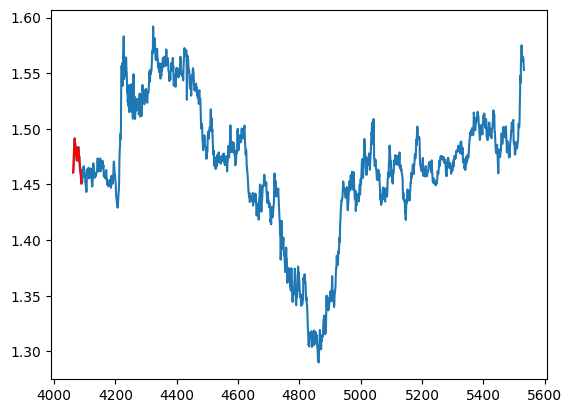

 77%|███████▋  | 4191/5435 [00:03<00:00, 1269.65it/s]

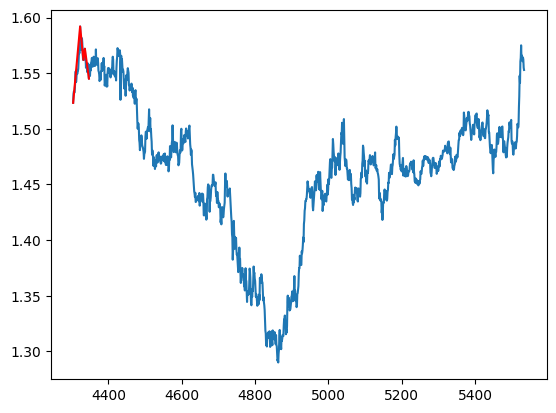

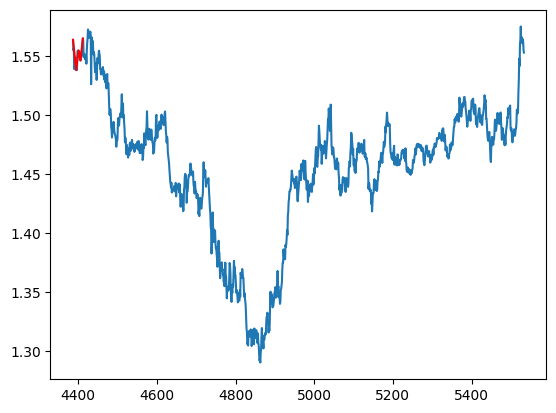

 82%|████████▏ | 4480/5435 [00:03<00:00, 1061.36it/s]

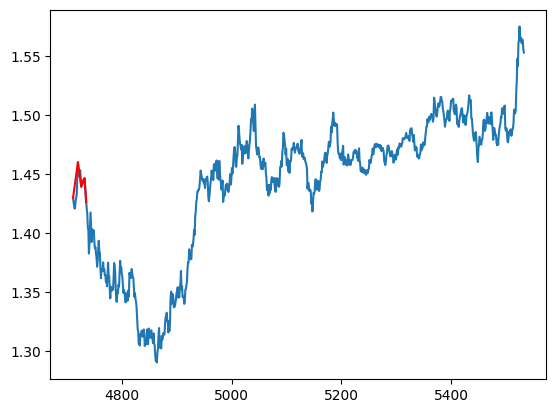

 85%|████████▌ | 4636/5435 [00:03<00:00, 1013.61it/s]

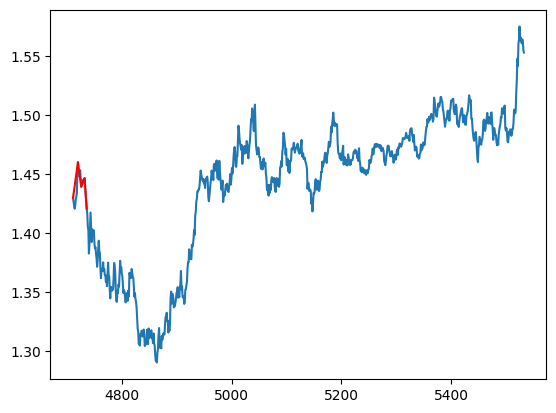

 90%|█████████ | 4892/5435 [00:04<00:00, 1038.90it/s]

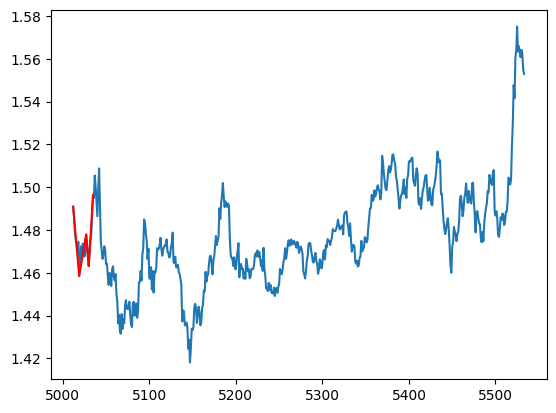

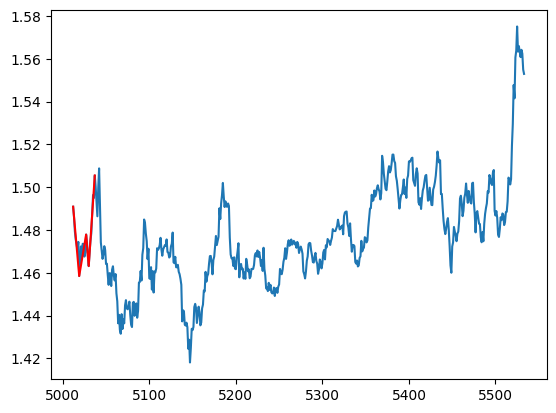

 92%|█████████▏| 5007/5435 [00:04<00:00, 727.79it/s] 

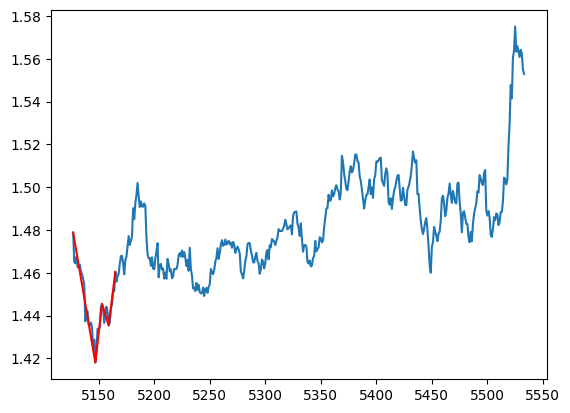

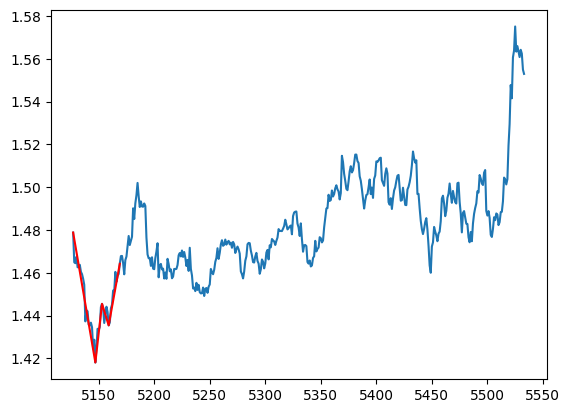

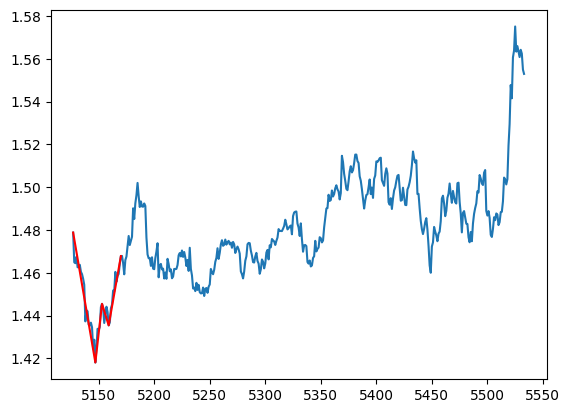

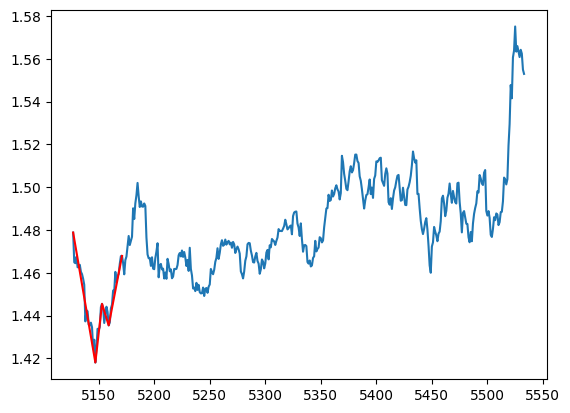

100%|██████████| 5435/5435 [00:05<00:00, 1082.89it/s]

No Pattern Detected


In [16]:
# Dados de close
close = data.Close.copy()

# varivael Margem de Erro de Detecção
err_allowed = 10.0/100

last_detected_pattern = None

for i in tqdm(range(100, len(close))):
    current_idx, current_pat, start, end, idx = peak_detect(close.values[:i])

    XA = current_pat[1] - current_pat[0]
    AB = current_pat[2] - current_pat[1]
    BC = current_pat[3] - current_pat[2]
    CD = current_pat[4] - current_pat[3]

    moves = [XA, AB, BC, CD]

    gart = get_gartley_hp(moves, err_allowed)
    butt = get_butterfly_hp(moves, err_allowed)
    bat = get_bat_hp(moves, err_allowed)
    crab = get_crab_hp(moves, err_allowed)

    harmonics = np.array([gart, butt, bat, crab])
    labels = ['Gartley', 'Butterfly', 'Bat', 'Crab']

    if np.any(harmonics == 1) or np.any(harmonics == -1):
        for j in range(0, len(harmonics)):
            if harmonics[j] == 1 or harmonics[j] == -1:
                signal = 'Bearish ' if harmonics[j] == -1 else 'Bullish '
                label = signal + labels[j] + ' Found'

                start = min(current_idx)
                end = max(current_idx)
                date = data.iloc[end].name

                last_detected_pattern = {
                    "start": start,
                    "end": i,
                    "current_idx": current_idx,
                    "current_pat": current_pat,
                    "label": label
                }

                plt.plot(np.arange(start,data.index[-1]),close.values[start:-1])
                plt.plot(current_idx, current_pat, c='r')
                plt.show()

# # Plot the last detected pattern using a candlestick chart
# if last_detected_pattern is not None:
#     x_values = np.arange(last_detected_pattern["start"], last_detected_pattern["end"] + 1)
#     y_values = close.values[last_detected_pattern["start"]:last_detected_pattern["end"] + 1]

#     plt.plot(x_values, y_values)
#     plt.plot(current_idx, current_pat, c='r')
#     plt.show()

#     print(current_idx, last_detected_pattern["start"], last_detected_pattern["end"])
#     print('Pattern : {}\nX :{}\nA :{}\nB :{}\nC :{}\nD :{}'.format(last_detected_pattern["label"],data.loc[last_detected_pattern["start"]], data.loc[current_idx[1]], data.loc[current_idx[2]], data.loc[current_idx[3]], data.loc[last_detected_pattern["end"]]))

else:
    print("No Pattern Detected")


Since we are in checking the full history of the data in a timeframe of 1D the larger the pattern the longer the trade
Is necessary to regard only the most recente patern detected and if targets dont were obtain in a timeline (TO CHECK the avg timeline of progression) 

Exemplo perfeito EURCAD com timeline the 1D e order = 5 